In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "True"
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import sys
import pandas as pd
from matplotlib import cm
import matplotlib as mp
import matplotlib.colors as mcolors
import scipy.special as sc
import scipy.optimize as so
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def exp_Ansatz(x,k,*d):
    # Ensure x is a numpy array
    x = np.array(x, dtype=float)
    d_aux=np.zeros_like(x)
    for i in range(len(d)-1):
        d_aux+=d[i] * x**(i+1) 
    d_aux+=d[len(d)-1]
    #d_aux=d0+d*x
    prob = np.ones_like(x)  # Initialize an array for probabilities
    
    # Handle each element in x independently due to range(1, x_i + 1)
    for i, x_i in enumerate(x):
        for j in range(1, int(x_i) + 1):  # Loop from 1 to x_i (inclusive)
            prob[i] *= (d_aux[i] + 1 - j) / (j * 2 ** (d_aux[i] / x_i))
    
    return prob*k



def Ansatz(x, k, d, d0):
    
    EE=2**(d*x+d0)
    AA=k*sc.binom(d*x+d0,x*L)/EE     
    return AA
    #A=sc.gammaln(d*x+d0 + 1) - sc.gammaln(x*L + 1) - sc.gammaln(d*x+d0 - x*L + 1)-np.log(2)*(d*x+d0)

    #return np.exp(A,dtype=np.float64)
    
    
def log_Ansatz(x, k, d, d0):
    
    A=np.log(k)+sc.gammaln(d*x+d0 + 1) - sc.gammaln(x*L*W + 1) - sc.gammaln(d*x+d0 - x*L*W + 1)-np.log(2)*(d*x+d0)
    return np.exp(A)
    
    
def logKL(X,Y):
    return sum(map(lambda x: x[0]*np.log(x[0]/x[1]),zip(X,Y)))

def bounds(x,L):
    
    eps=10**(-6)
    #print("x",len(x))
    aux=np.array(x[0:int(L/2)])
    #print(aux.argmax())
    max=aux.argmax()
    if max<int(L/2):
        return max
    else:
        return int(L/2)-1


def initial_guess(x,L,eps):
    maxi=bounds(x,L)
    delta_left=maxi
    while delta_left>0 and x[delta_left]>eps:
        delta_left-=1
    delta_left+=1
    delta_right=maxi
    while delta_right<int(L*0.48) and x[delta_right]>eps:
        delta_right+=1
    delta_right-=1
    return [delta_left,maxi,delta_right]

def fit(F,X,Y,guesses):
    Nd=len(guesses)
    Ntry=100
    KL=10
    RV=[X[0],X[len(X)-1]]
    try:
        A=so.curve_fit(F,X,Y,p0=guesses)
        YY=F(X,*A[0])
        KL_try=logKL(Y/np.sum(Y),YY/np.sum(YY))
        bestA=A
        bestKL=KL_try
        bestRV=[0,len(X)-1]
    except:
        bestA=[np.array([np.nan for x in range(Nd)]),np.full((Nd,Nd),np.nan)]
        KL_try=np.nan
        bestKL=np.nan
        bestRV=RV
        
    
    if KL_try>0.01:
        print("INSIDE")
        for i in range(Ntry):
            try:
                guesses[Nd-1]-=1
                X_test=X[:len(X)-i]
                Y_test=Y[:len(Y)-i]
                A=so.curve_fit(F,X_test,Y_test,p0=guesses)
                YY=F(X,A[0][0],A[0][1],A[0][2])
                KL_test=logKL(Y_test/np.sum(Y_test),YY/np.sum(YY))
                if KL_test<bestKL:
                    bestKL=KL_test
                    bestA=A
                    bestRV=[0,len(X)-i-1]
                    
                print(i,KL_test)
            except:
                print("no convergence reached")
                break
    
    return [bestA,bestKL,bestRV]



def d(r,d0,d1,d2):
    return d0+r*d1+d2*(r**2)

def der_d(r,d0,d1,d2):
    return d1+2*r*d2

def grad_KL(r,d0,d1,d2):
    dr=d(r,d0,d1,d2)
    return -(sc.digamma(dr+1)-sc.digamma(dr-r*L+1)-dr/2)
    
def av_min(P,x,d0,d1,d2,n):
    sum=0
    for p in range(len(P)):
        aux=P[p]*grad_KL(x[p],d0,d1,d2)
        sum+=P[p]*grad_KL(x[p],d0,d1,d2)*(float(x[p])*1.0)**n
    return sum



def opt_step(P,x,k,d0,d1,d2,alp):
    
    
    d0_new=d0-alp*av_min(P,x,d0,d1,d2,0)
    d1_new=d1-alp*av_min(P,x,d0,d1,d2,1)
    d2_new=d2-alp*av_min(P,x,d0,d1,d2,2)
    k_new=k+alp*np.sum(P)
    
    return [k_new,d0_new,d1_new,d2_new]

def optimizer(P,k,d0,d1,d2,alp,N,alp_I,alp_F):
    
    KL=[]
    x=np.arange(alp_I,alp_F,1)/L
    k_aux=k
    d0_aux=d0
    d1_aux=d1
    d2_aux=d2
    print("initial",k,d0,d1,d2)
    for i in range(N):
        #print(d0_aux,d1_aux,d2_aux)
        aux=opt_step(P,x,k_aux,d0_aux,d1_aux,d2_aux,alp)
        k_aux=aux[0]
        d0_aux=aux[1]
        d1_aux=aux[2]
        d2_aux=aux[3]
        Y=Ansatz(x,k,d0_aux,d1_aux)
        KL.append(logKL(P,Y))
    print("d0","d1","d2")
    print(k_aux,d0_aux,d1_aux,d2_aux)
    return [KL,[k_aux,d0_aux,d1_aux,d2_aux]]
    

In [3]:
l=[200,250,300]
W=1
GI=9980
GF=10020
dG=1
NR=1000
NS=1000
n_mean=10
delta=0
start=0
dx=0.01
eps=10**(-5)
norm = mcolors.Normalize(vmin=np.abs(l[0]), vmax=np.abs(l[len(l)-1]))

G=[i for i in range(GI,GF+dG,dG)]
colors = [(0.0, "green"),(0.33333, 'blue'),(0.66666,"brown"),(1.0, 'red')]
# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('custom_blue_green', colors)

#AA=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,29,30,31,32,33,34,35,36,37,38,39,40]
AA=[i for i in range(0,len(G))]
print(AA)

ID0=[[] for L in l]
DID0=[[] for L in l]
KL=[[] for L in l]
RV=[[] for L in l]

alp=0.5
PDF=[[np.zeros(L) for g in G] for L in l]
DPDF=[[np.zeros(L) for g in G] for L in l]
for ll in range(len(l)):
    L=l[ll]
    name_figs="L"+str(L)+"W"+str(W)+"NS"+str(NS)+"NR"+str(NR)+"D.png"
    for g in range(len(G)):
        name=[ "M"+str(5)+"L"+str(L)+"W"+str(W)+"NS"+str(NS)+"NR"+str(NR)+"G"+str(G[g])+"D.txt"+str(j+1) for j in range(n_mean)]
        file=[pd.read_csv(name[j],sep="\s+",dtype="a") for j in range(n_mean)]
        file=[ files.astype(float) for files in file] 
        PDF_1=[[0 for j in range(L*W)] for i in range(n_mean)]
        DPDF_1=[[0 for j in range(L*W)] for i in range(n_mean)]
        for i in range(n_mean):
            PDF_1[i][0]=file[i]["D"][0]/NS
            PDF_1[i][0]=0
            DPDF_1[i][0]=file[i]["dD"][0]/NS
            for j in range(1,L*W):
                PDF_1[i][j]=(file[i]["D"][j]-file[i]["D"][j-1])/NS
                DPDF_1[i][j]=(file[i]["dD"][j]+file[i]["dD"][j-1])/NS
        PDF_1=np.array(PDF_1)
        DPDF_1=np.array(DPDF_1)
        PDF_1=np.mean(PDF_1,axis=0)
        DPDF_1=np.mean(DPDF_1,axis=0)
        PDF[ll][g]=PDF_1
        DPDF[ll][g]=DPDF_1
     
    for i in range(len(AA)):
        par=initial_guess(PDF[ll][AA[i]],L*W,eps) #FOR PBC ONLY TRUST MAX
        expPDF=[]
        X=[]

        for j in range(L*W):
            if j%2==par[1]%2:
                expPDF.append(PDF[ll][AA[i]][j])
                X.append(j)

        auxPDF=np.array(PDF[ll][AA[i]])
        XX=np.array([i for i in range(L*W)])
        auxPDF[XX%2!=par[1]%2]=0
        aux2PDF=auxPDF
        auxPDF[:int(L*W)-1]+=aux2PDF[1:]/2.0
        auxPDF[1:]+=aux2PDF[:int(L*W)-1]/2.0
        #expPDF=auxPDF
        #X=XX
            
        par_exp=initial_guess(expPDF,len(X),eps)
        print(par_exp)
        Xexp=X[par_exp[0]:par_exp[2]]
       
        x=np.arange(X[par_exp[0]],X[par_exp[2]],2)
        
     
        yy=expPDF[par_exp[0]:par_exp[2]]
        init_0=[1.0,1.0,0.001,0.0000001,par[1]]
        A,KL_aux,RV_aux=fit(exp_Ansatz,x,yy,init_0)
        
        #A=so.curve_fit(exp_Ansatz,x,yy,p0=(1.0,1.0,par[1]))
        ID0[ll].append(A[0])
        DID0[ll].append(np.sqrt(np.diag(A[1])))
        RV[ll].append(RV_aux)
        print(RV_aux)
        print(RV_aux[0],RV_aux[1])
        print(x[RV_aux[0]:RV_aux[1]])
        print(KL_aux)
        print(A)
        print(np.sqrt(np.diag(A[1])))
        yyexp=exp_Ansatz(x,*A[0])
        KL[ll].append(KL_aux)
        plt.figure()
        plt.title("Hamming Distribution for"+ "\n"+"$h/J="+str(G[i])+r"\cdot 10^{-4}\;L="+str(L)+"$")
        
        plt.fill_between(x[RV_aux[0]:RV_aux[1]],0,1,color="red",alpha=0.1)
        plt.plot(PDF[ll][AA[i]])
        plt.plot(x,yyexp,linestyle="dashed")
        #plt.scatter(x,yy)
        plt.yscale("log")
        plt.show()
        
        
          

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


FileNotFoundError: [Errno 2] No such file or directory: 'M5L200W1NS1000NR1000G9980D.txt1'

<>:55: SyntaxWarning: invalid escape sequence '\;'
<>:55: SyntaxWarning: invalid escape sequence '\;'
/tmp/ipykernel_119070/1638460830.py:55: SyntaxWarning: invalid escape sequence '\;'
  plt.title("$"+strdd+"\;$"+"for different values of $h/J$ \n $N_{snapshots}="+str(NS)+"$",fontsize=20)


5


<Figure size 640x480 with 0 Axes>

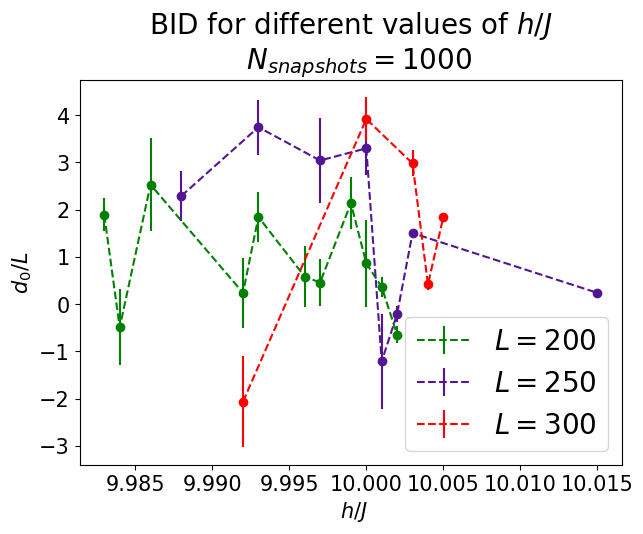

<Figure size 640x480 with 0 Axes>

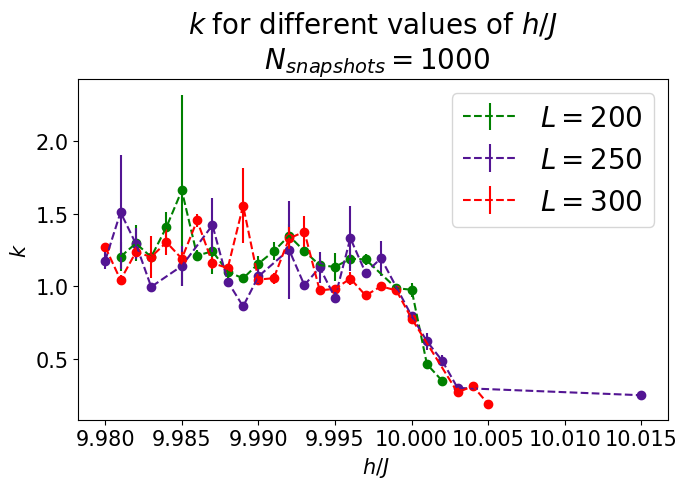

<Figure size 640x480 with 0 Axes>

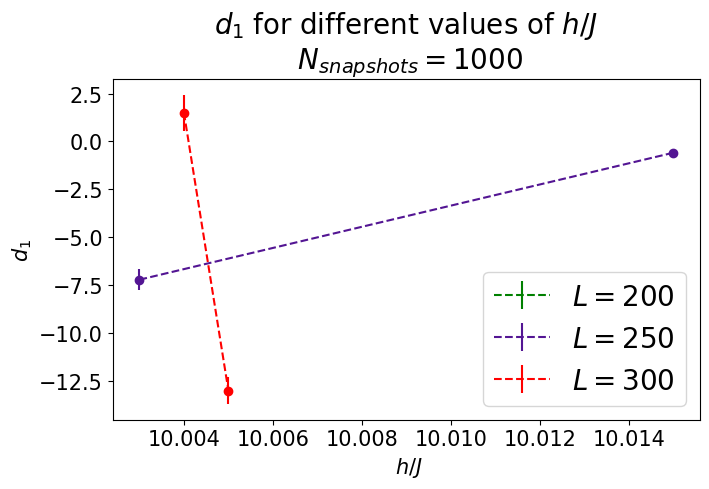

<Figure size 640x480 with 0 Axes>

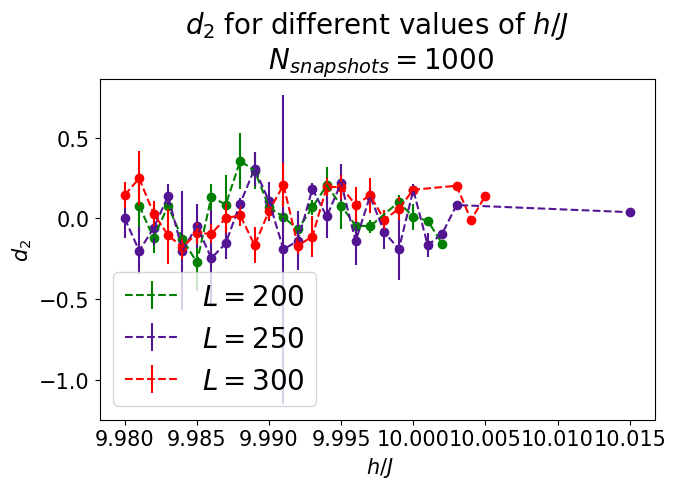

<Figure size 640x480 with 0 Axes>

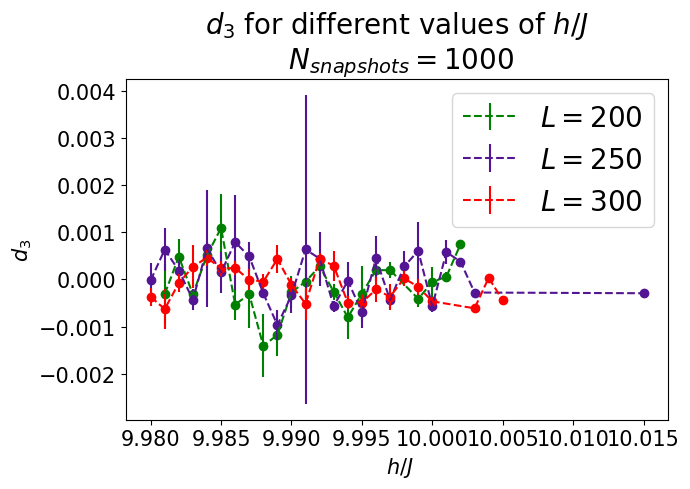

<Figure size 640x480 with 0 Axes>

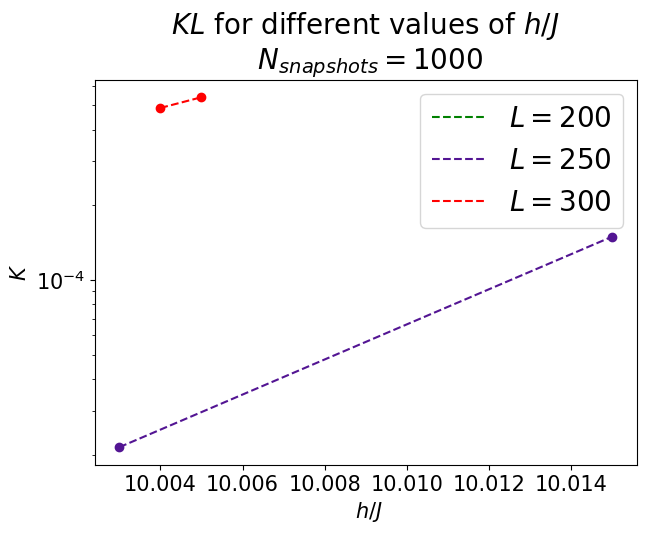

In [47]:
ID0=np.array(ID0)
DID0=np.array(DID0)
Ds=len(ID0[0,0,:])
print(Ds)
KL=np.array(KL)
deltaG=0.001
xx=np.array([deltaG*G[a] for a in AA])
deltaKL=0.001


plt.figure()
fig,axis=plt.subplots(1,1,figsize=(7,5))
plt.title("BID for different values of $h/J$ \n  $N_{snapshots}="+str(NS)+"$",fontsize=20)
plt.xlabel(" $h/J$",fontsize=15)
plt.ylabel("$d_0/L$",fontsize=15)
for i in range(len(l)):
    AuxKL=KL[i,:]
    AuxID=ID0[i,:,Ds-1]/l[i]
    AuxDID=DID0[i,:,Ds-1]/l[i]
    Auxx=xx

    Auxx=xx[AuxKL<deltaKL]
    AuxID=AuxID[AuxKL<deltaKL]
    AuxDID=AuxDID[AuxKL<deltaKL]
    AuxKL=AuxKL[AuxKL<deltaKL]
    
    Auxx=Auxx[AuxDID<1.0]
    AuxID=AuxID[AuxDID<1.0]
    AuxKL=AuxKL[AuxDID<1.0]
    AuxDID=AuxDID[AuxDID<1.0]

    #axis.errorbar(xx,ID0[i,:,2]/l[i],yerr=DID0[i,:,2]/l[i],linestyle="dashed",color=cmap(norm(l[i])),label="$L="+str(l[i])+"$")
    #axis.errorbar(xx,ID0[i,:,2]/l[i],linestyle="dashed",color=cmap(norm(l[i])),label="$L="+str(l[i])+"$")
    axis.errorbar(Auxx,AuxID,yerr=AuxDID,linestyle="dashed",color=cmap(norm(l[i])),label="$L="+str(l[i])+"$")
    axis.scatter(Auxx,AuxID,color=cmap(norm(l[i])))    
#axis.scatter(xx,ID0[i,:,2]/l[i],color=cmap(norm(l[i])))
axis.legend(fontsize=20)
# We change the fontsize of minor ticks label 
axis.tick_params(axis='both', which='major', labelsize=15)
axis.tick_params(axis='both', which='minor', labelsize=10)
#sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
#sm.set_array([])  # ScalarMappable needs an array, even an empty one is fine
#cbar = plt.colorbar(sm,ax=axis,label='$L$')
#cbar.set_label('$L$', fontsize=14)
plt.savefig("BID"+name_figs)

plt.show()
for dd in range(Ds-1):
    plt.figure()
    fig,axis=plt.subplots(1,1,figsize=(7,5))
    if dd==0:
        strdd="k"
    else:
        strdd="d_"+str(dd)
    plt.title("$"+strdd+"\;$"+"for different values of $h/J$ \n $N_{snapshots}="+str(NS)+"$",fontsize=20)
    plt.xlabel(" $h/J$",fontsize=15)
    plt.ylabel("$"+strdd+"$",fontsize=15)
    for i in range(len(l)):
    
        AuxKL=KL[i,:]
        AuxID=ID0[i,:,dd]
        AuxDID=DID0[i,:,dd]
        Auxx=xx

        Auxx=xx[AuxKL<deltaKL]
        AuxID=AuxID[AuxKL<deltaKL]
        AuxDID=AuxDID[AuxKL<deltaKL]
        AuxKL=AuxKL[AuxKL<deltaKL]
    
        Auxx=Auxx[AuxDID<1.0]
        AuxID=AuxID[AuxDID<1.0]
        AuxKL=AuxKL[AuxDID<1.0]
        AuxDID=AuxDID[AuxDID<1.0]

    #axis.errorbar(xx,ID0[i,:,2]/l[i],yerr=DID0[i,:,2]/l[i],linestyle="dashed",color=cmap(norm(l[i])),label="$L="+str(l[i])+"$")
    #axis.errorbar(xx,ID0[i,:,2]/l[i],linestyle="dashed",color=cmap(norm(l[i])),label="$L="+str(l[i])+"$")
        axis.errorbar(Auxx,AuxID,yerr=AuxDID,linestyle="dashed",color=cmap(norm(l[i])),label="$L="+str(l[i])+"$")
        axis.scatter(Auxx,AuxID,color=cmap(norm(l[i])))
    axis.legend(fontsize=20)
# We change the fontsize of minor ticks label 
    axis.tick_params(axis='both', which='major', labelsize=15)
    axis.tick_params(axis='both', which='minor', labelsize=10)
#sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
#cbar = plt.colorbar(sm,ax=axis,label='$L$')
#cbar.set_label('$L$', fontsize=14)
    plt.tight_layout()
    plt.savefig(strdd+"L"+str(i)+name_figs)


plt.figure()
fig,axis=plt.subplots(1,1,figsize=(7,5))
plt.title("$KL$ for different values of $h/J$ \n $N_{snapshots}="+str(NS)+"$",fontsize=20)
plt.xlabel(" $h/J$",fontsize=15)
plt.ylabel("$K$",fontsize=15)
plt.yscale("log")
for i in range(len(l)):
    
    AuxKL=KL[i,:]
    AuxID=ID0[i,:,1]
    AuxDID=DID0[i,:,1]
    Auxx=xx

    Auxx=xx[AuxKL<deltaKL]
    AuxID=AuxID[AuxKL<deltaKL]
    AuxDID=AuxDID[AuxKL<deltaKL]
    AuxKL=AuxKL[AuxKL<deltaKL]
    
    Auxx=Auxx[AuxDID<1.0]
    AuxID=AuxID[AuxDID<1.0]
    AuxKL=AuxKL[AuxDID<1.0]
    AuxDID=AuxDID[AuxDID<1.0]

    #axis.errorbar(xx,ID0[i,:,2]/l[i],yerr=DID0[i,:,2]/l[i],linestyle="dashed",color=cmap(norm(l[i])),label="$L="+str(l[i])+"$")
    #axis.errorbar(xx,ID0[i,:,2]/l[i],linestyle="dashed",color=cmap(norm(l[i])),label="$L="+str(l[i])+"$")
    axis.errorbar(Auxx,AuxKL,linestyle="dashed",color=cmap(norm(l[i])),label="$L="+str(l[i])+"$")
    axis.scatter(Auxx,AuxKL,color=cmap(norm(l[i])))
    
axis.legend(fontsize=20)
# We change the fontsize of minor ticks label 
axis.tick_params(axis='both', which='major', labelsize=15)
axis.tick_params(axis='both', which='minor', labelsize=10)
#sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
#cbar = plt.colorbar(sm,ax=axis,label='$L$')
#cbar.set_label('$L$', fontsize=14)
plt.savefig("KL"+name_figs)




<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_119070/3923642833.py:2: SyntaxWarning: invalid escape sequence '\c'
  plt.title("Hamming Distribution for"+ "\n"+"$h/J="+str(G[AA[i]])+"\cdot 10^{-4}\;$")


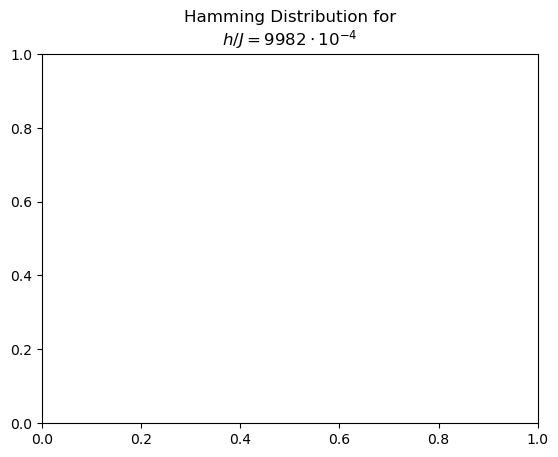

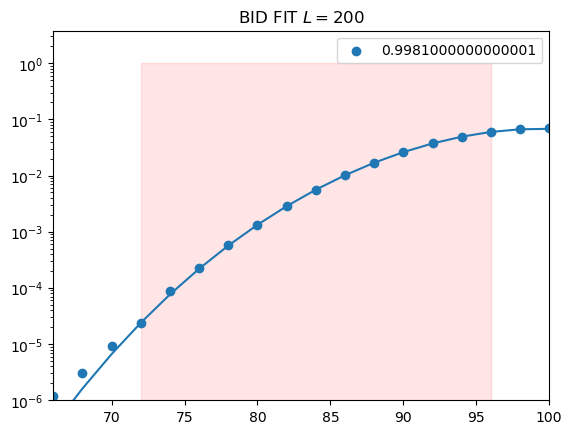

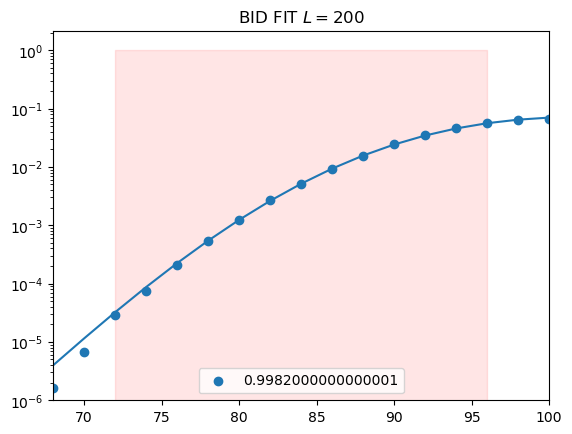

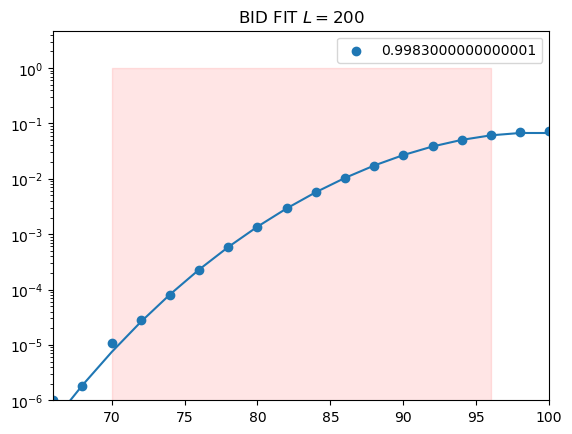

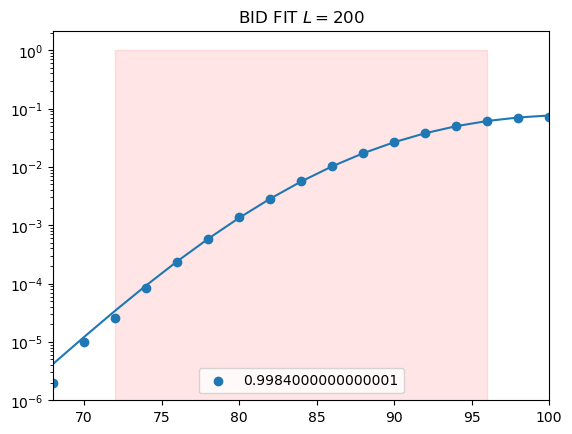

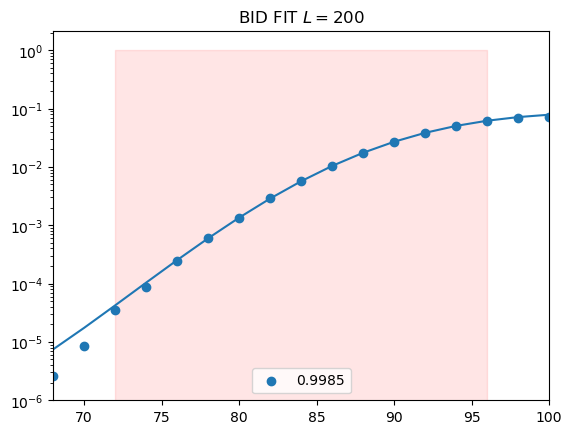

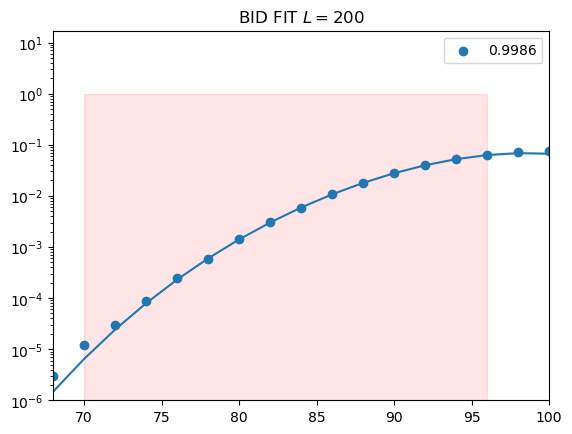

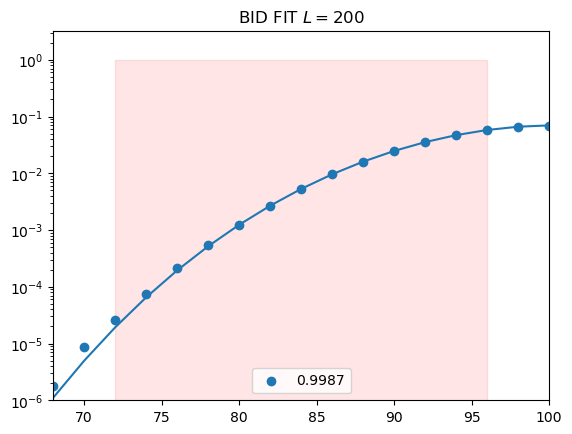

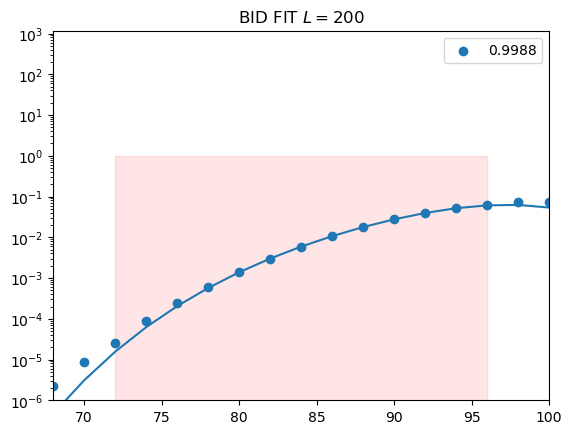

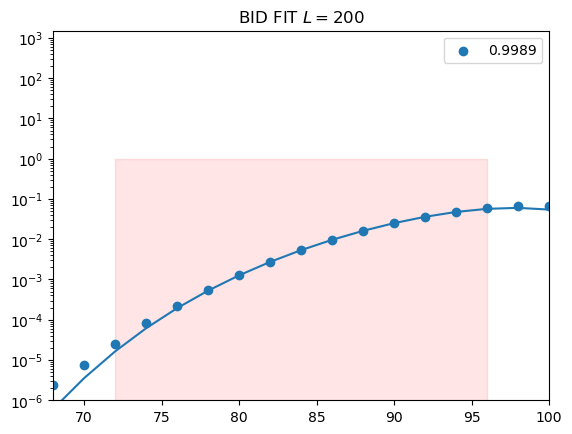

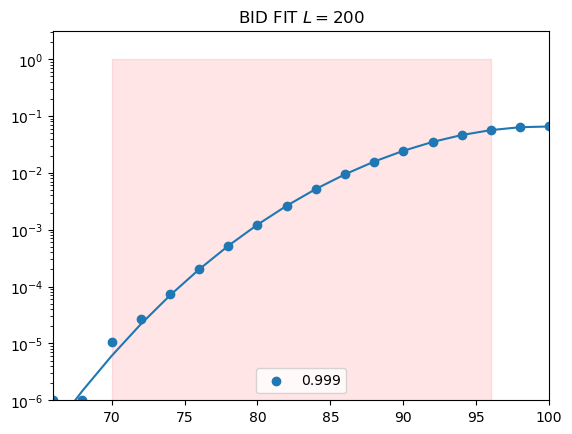

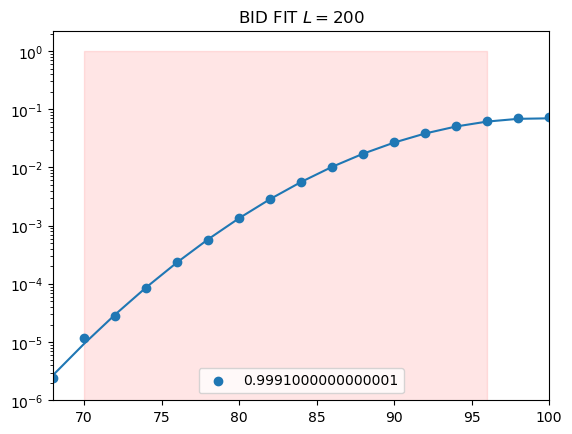

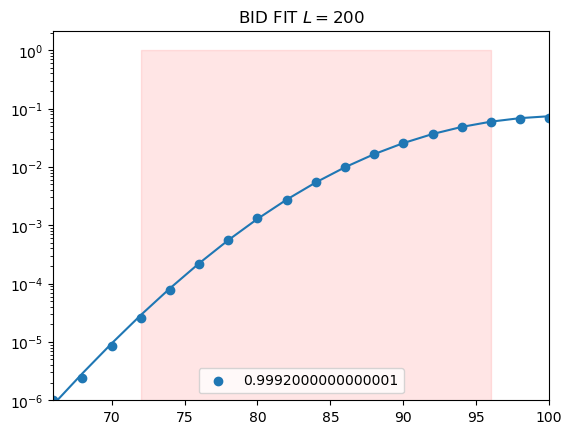

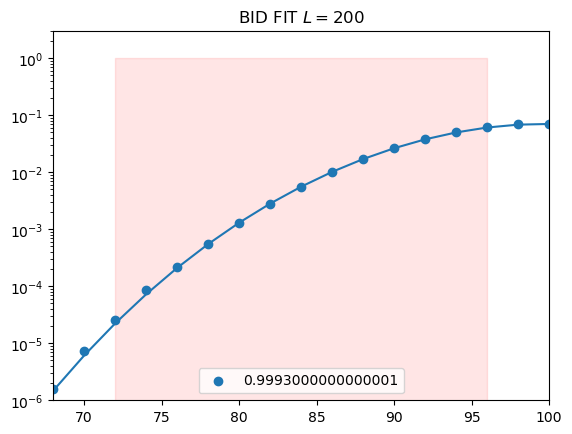

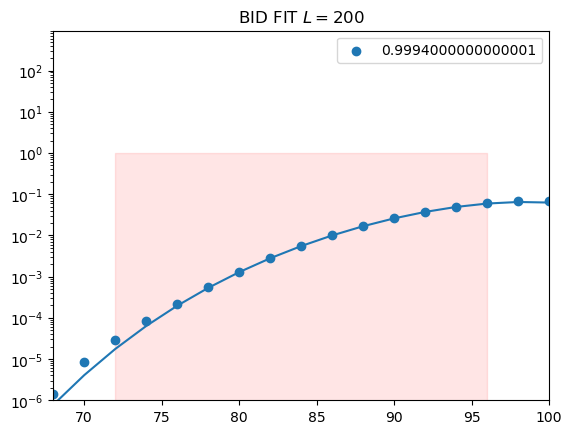

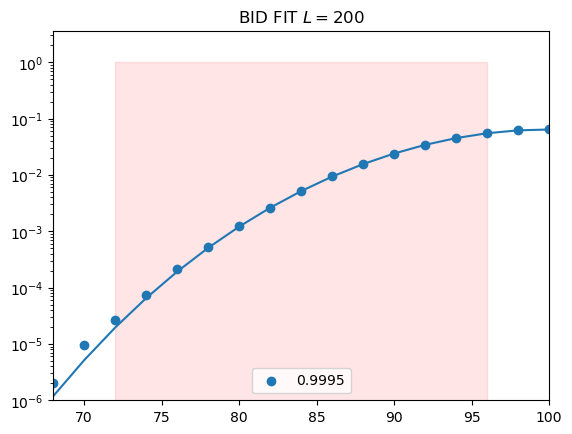

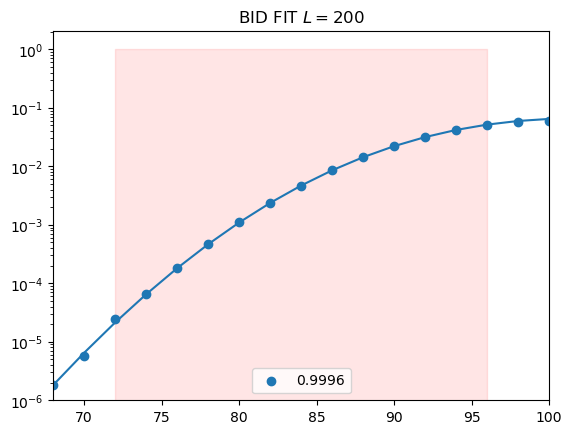

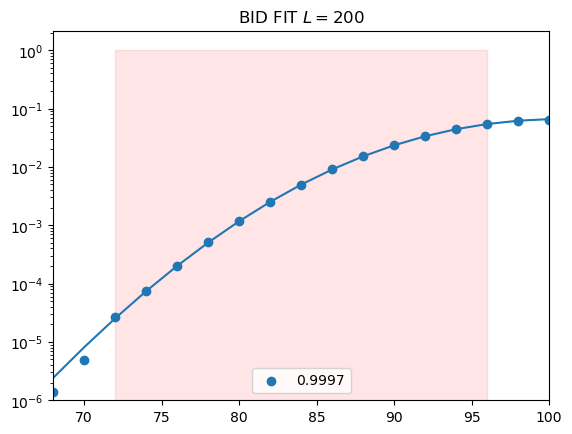

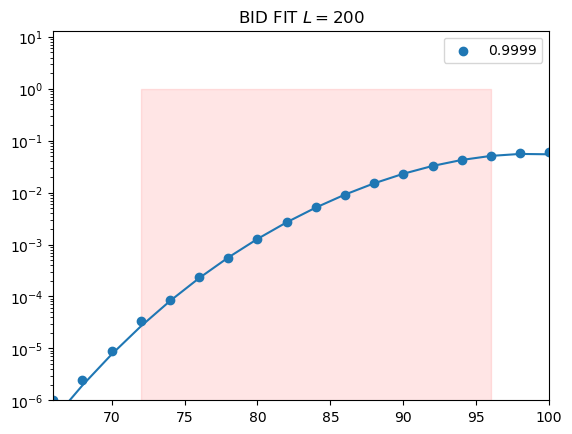

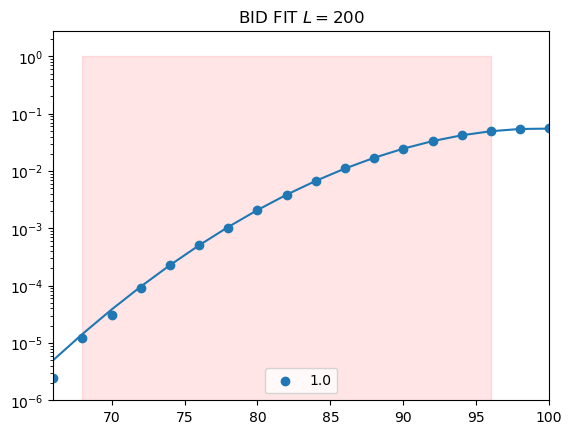

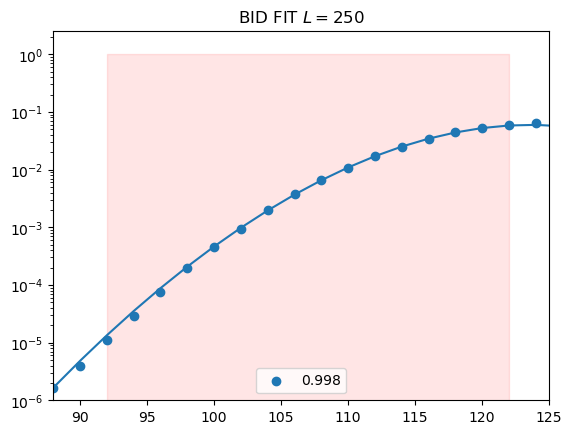

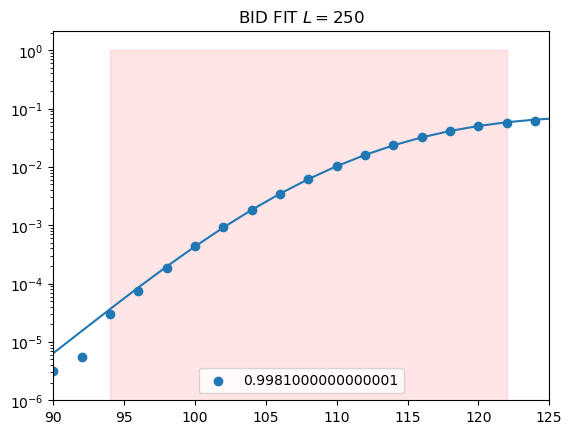

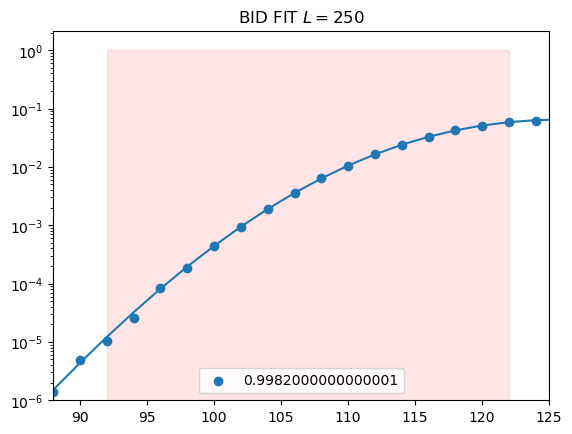

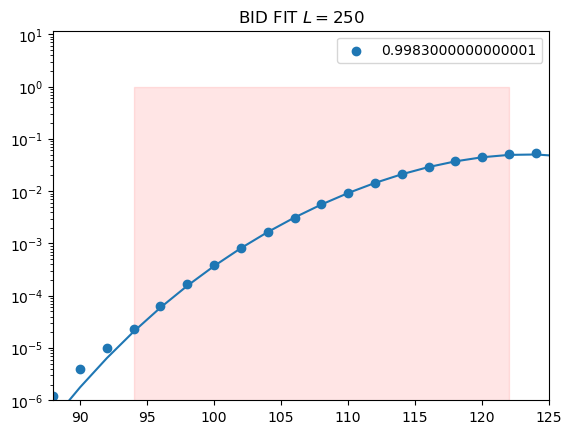

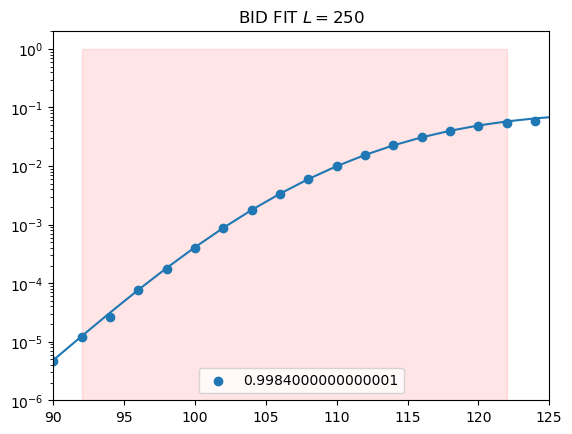

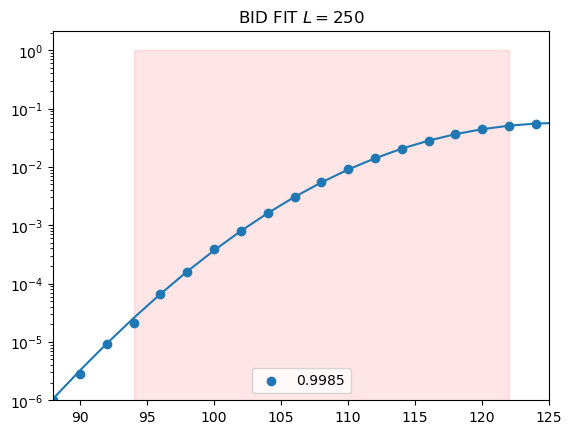

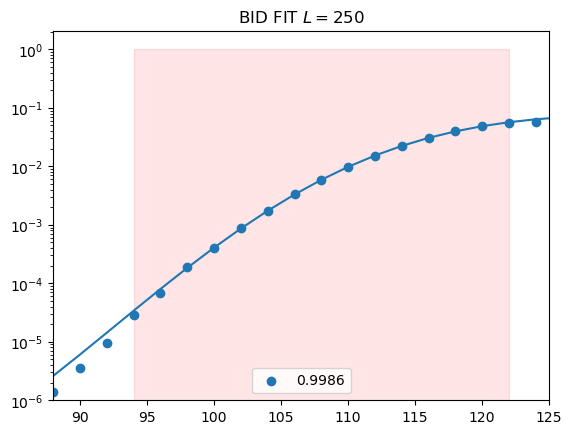

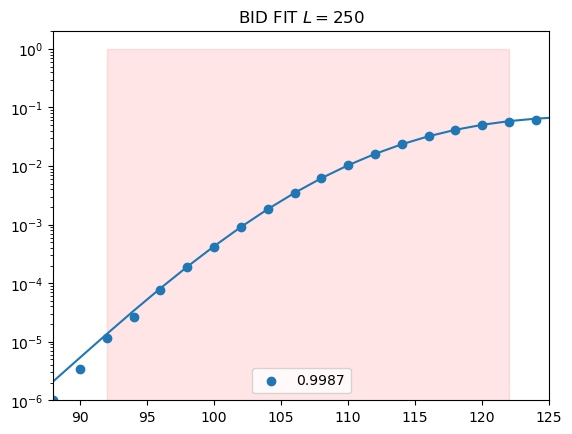

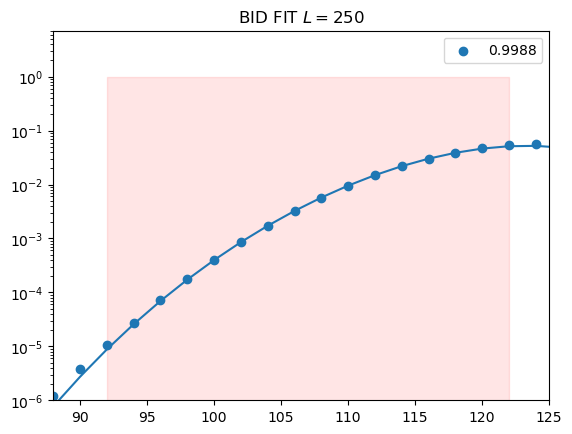

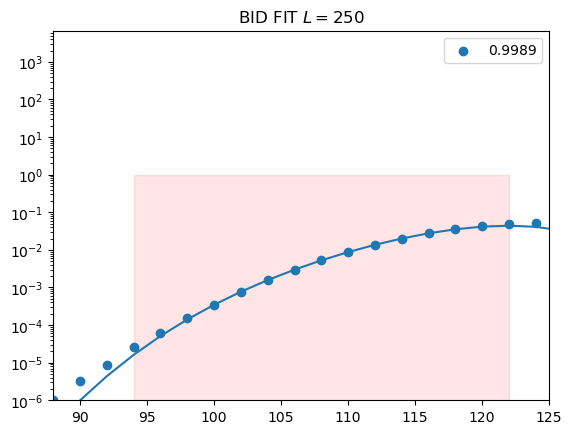

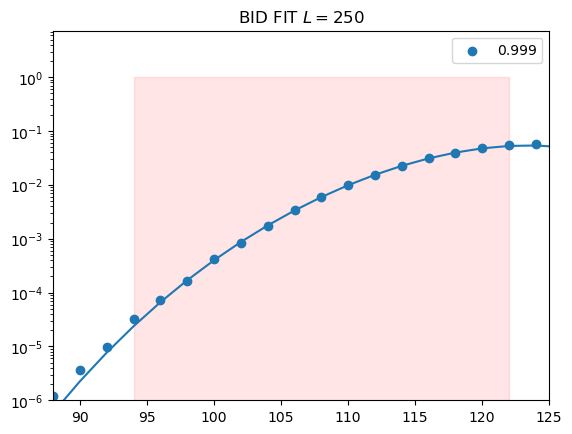

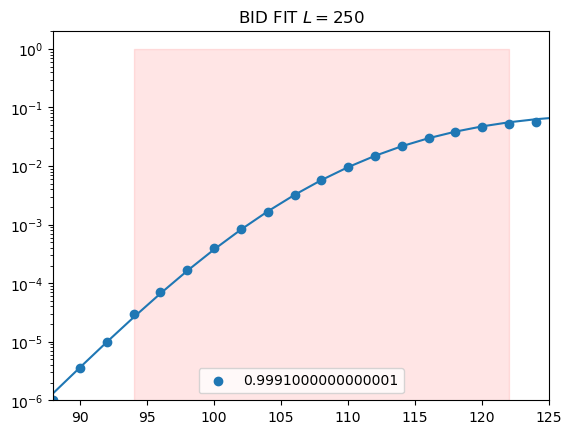

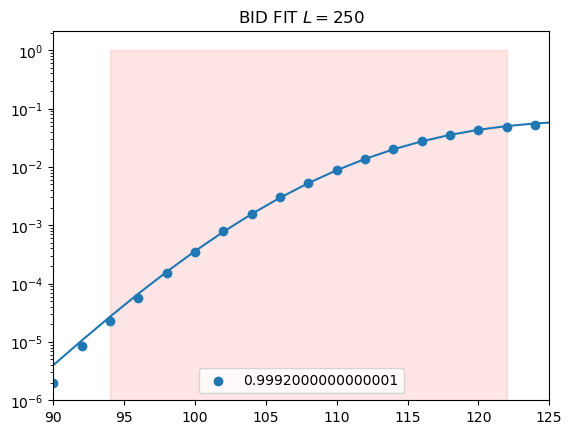

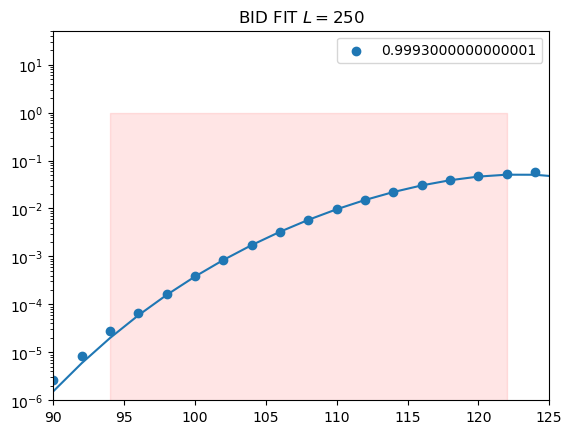

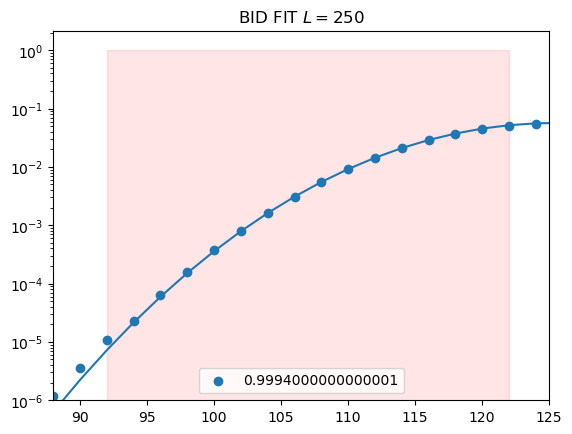

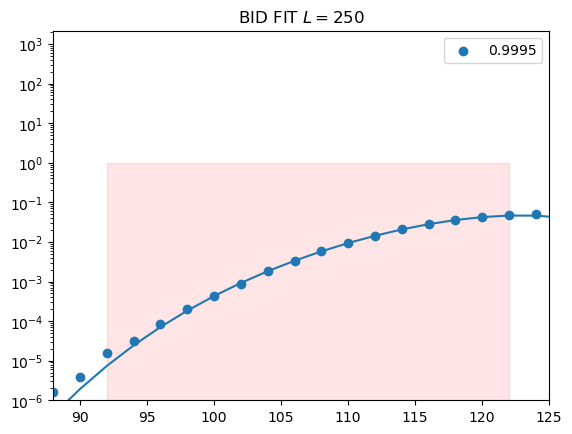

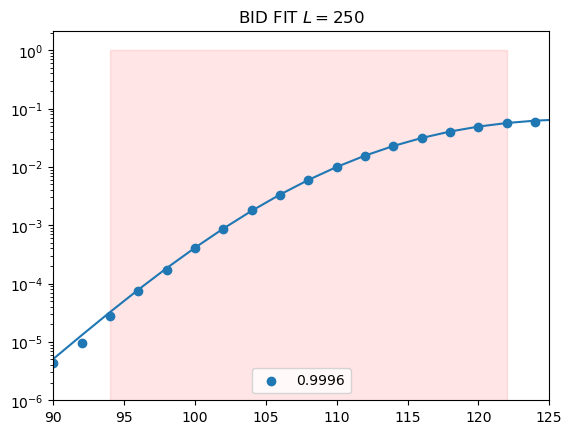

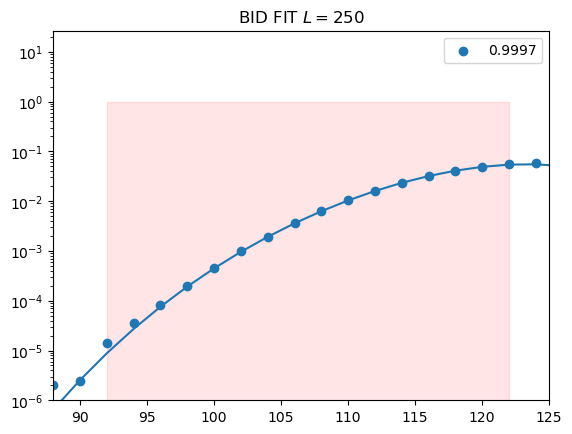

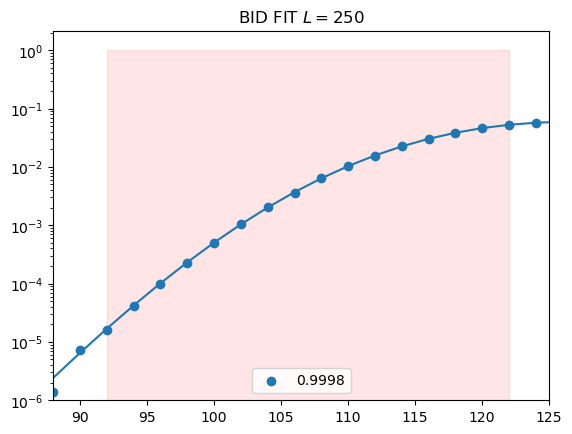

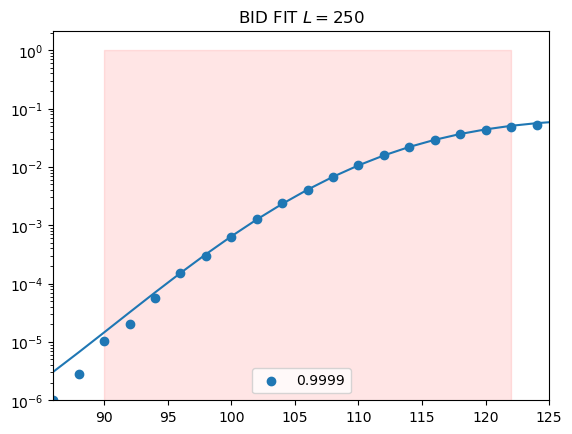

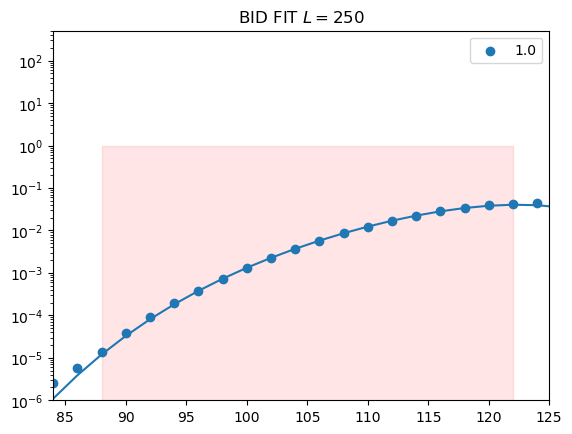

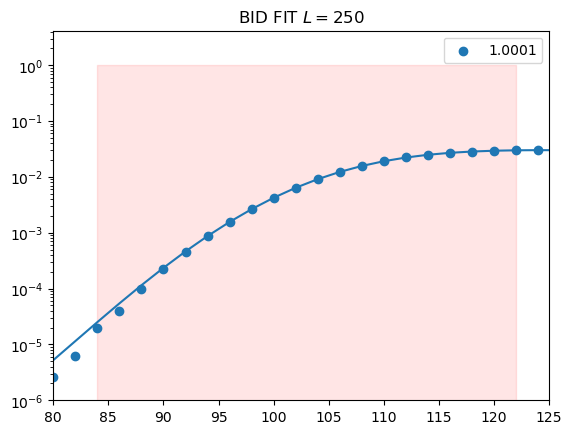

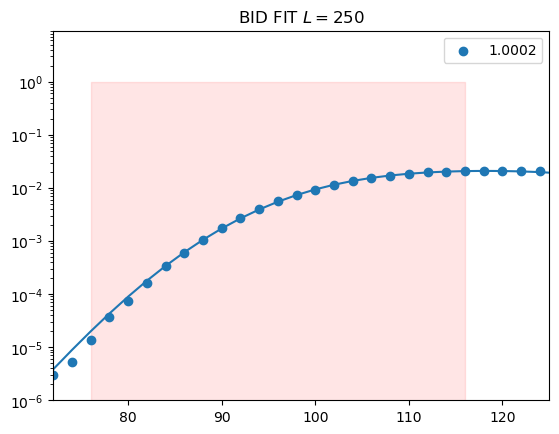

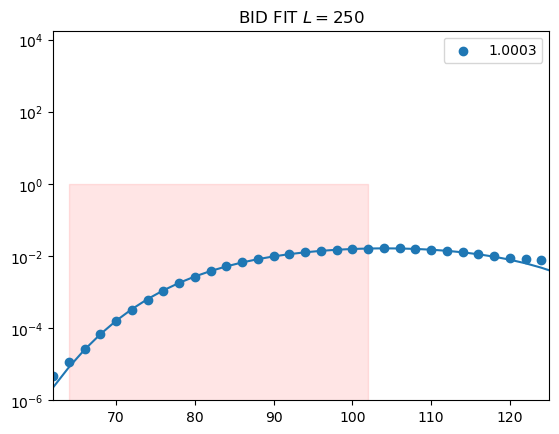

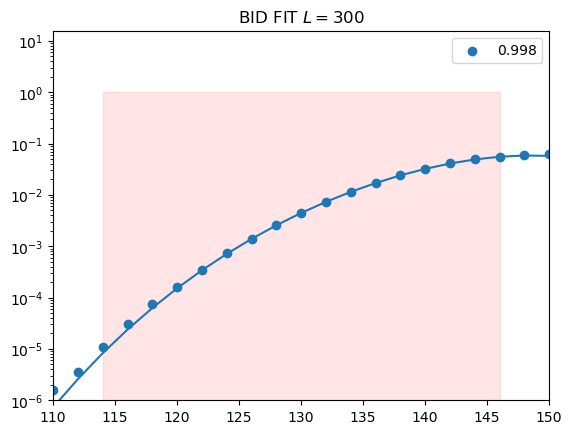

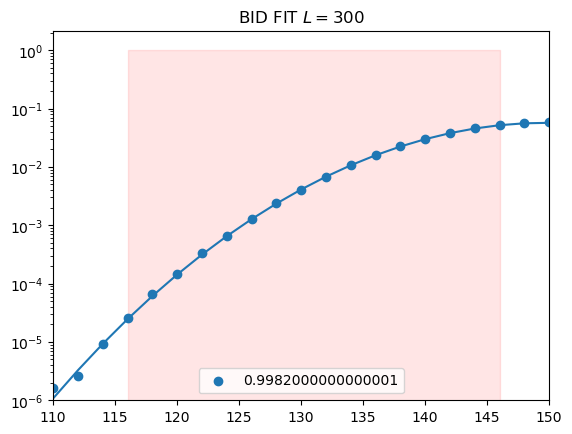

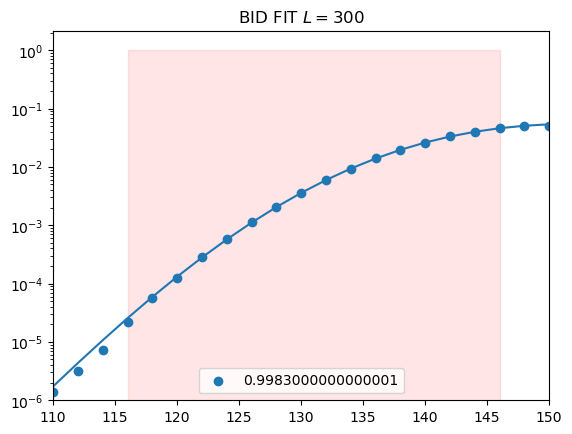

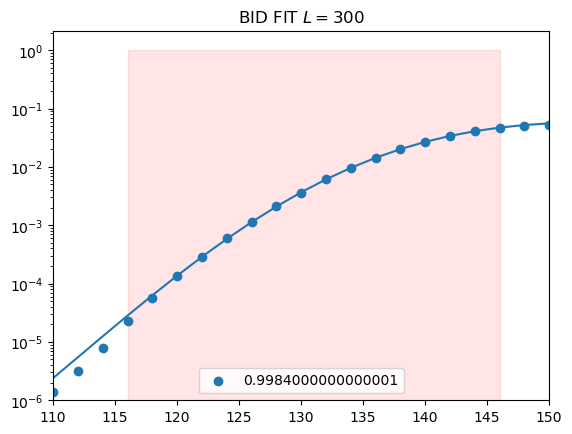

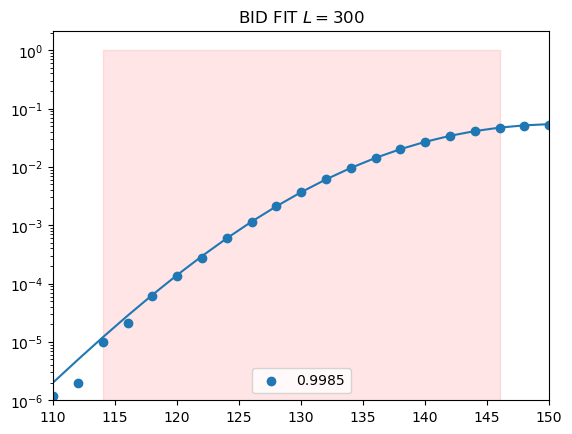

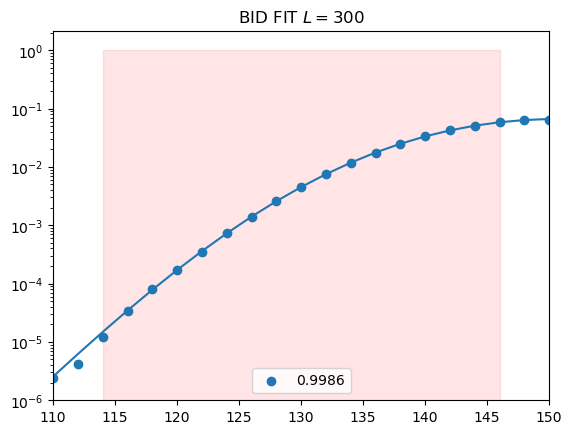

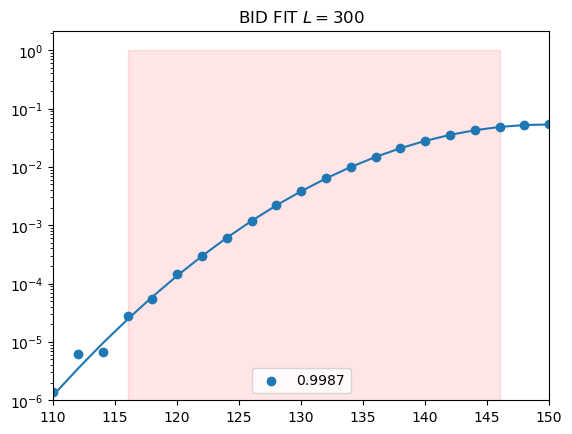

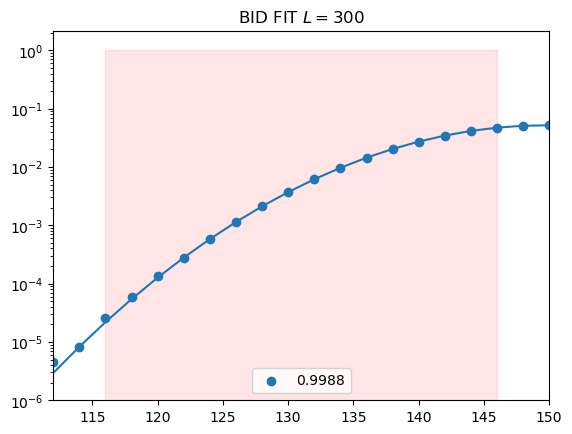

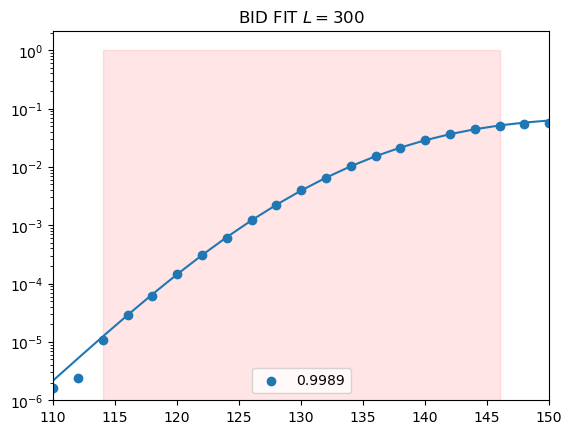

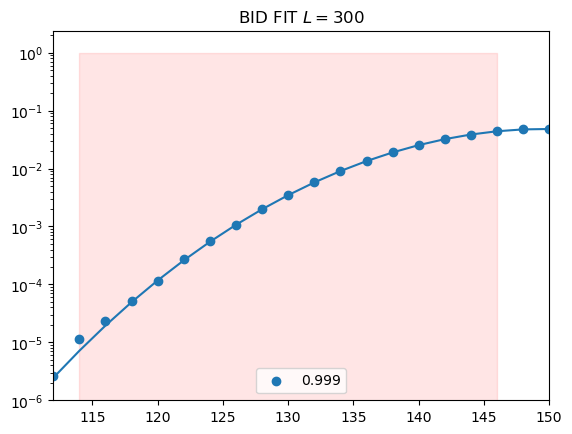

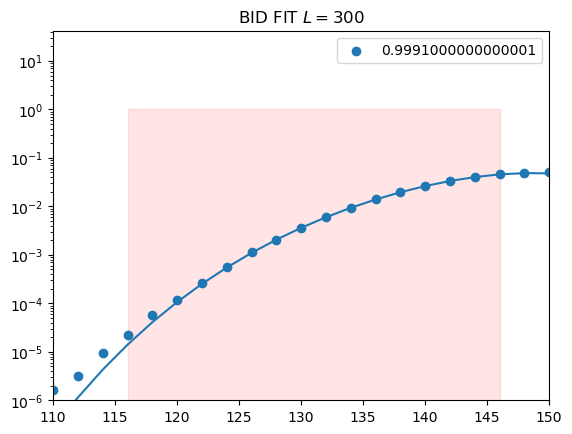

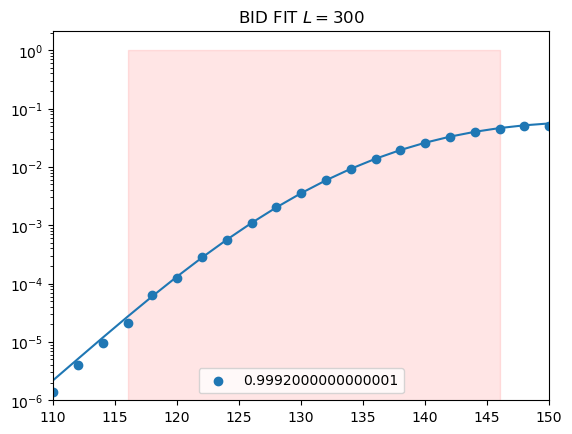

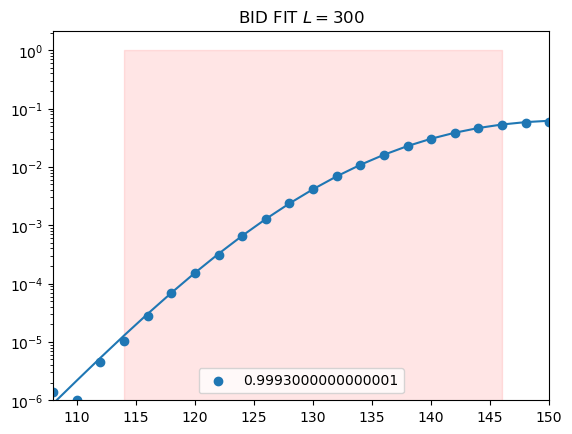

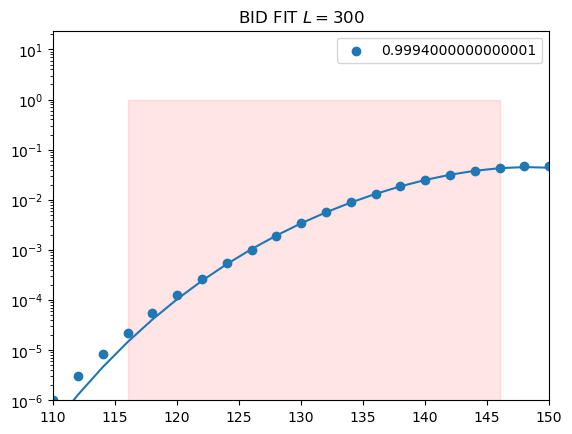

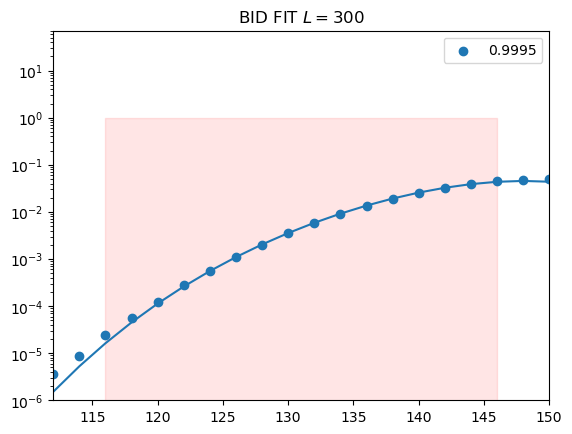

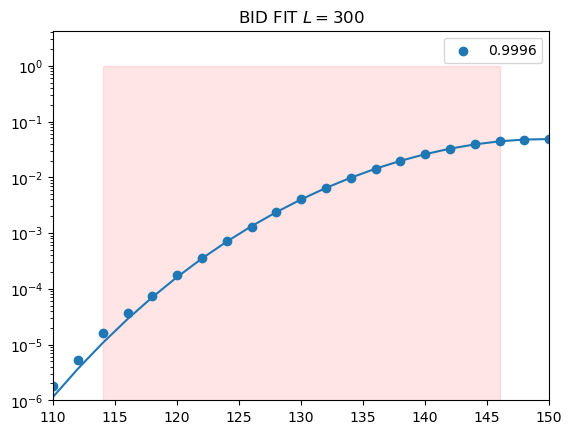

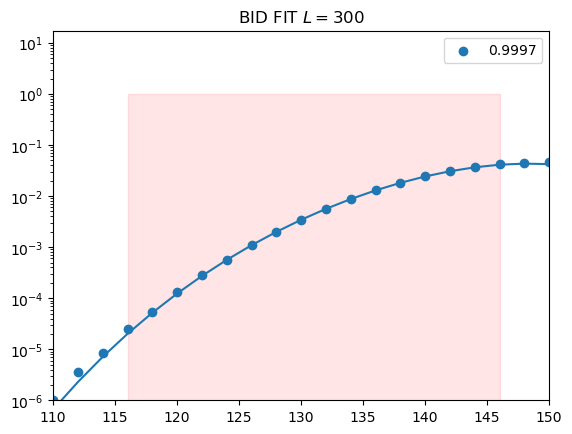

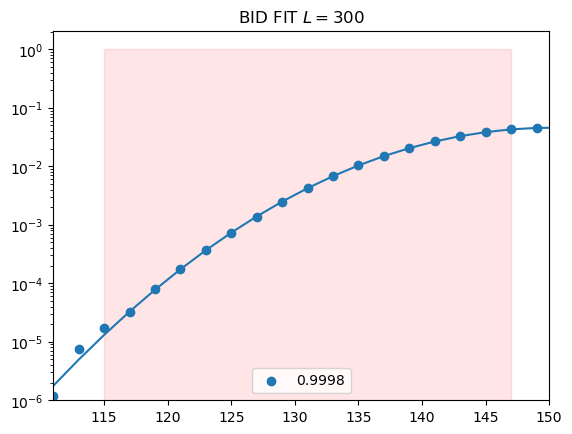

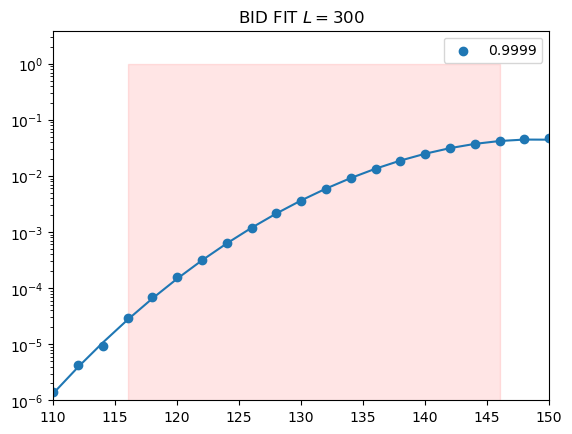

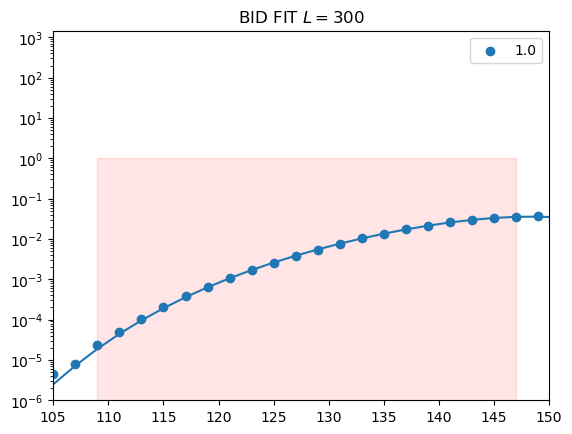

In [46]:
#MODEL VALIDATION
plt.title("Hamming Distribution for"+ "\n"+"$h/J="+str(G[AA[i]])+"\cdot 10^{-4}\;$")
for ll in range(len(l)):
    L=l[ll]
    for i in range(len(AA)):
        if KL[ll,AA[i]]<deltaKL and DID0[ll,AA[i],1]/L<1.0:
            plt.figure()
            plt.title("BID FIT "+r"$L="+str(L)+"$")
            
            par=initial_guess(PDF[ll][AA[i]],L*W,eps) #FOR PBC ONLY TRUST MAX
            expPDF=[]
            X=[]
            for j in range(L*W):
                if j%2==par[1]%2 and j!=0:
                    expPDF.append(PDF[ll][AA[i]][j])
                    X.append(j)
            par_exp=initial_guess(expPDF,len(X),eps)
            Xexp=X[par_exp[0]:par_exp[1]]
            YPDF=expPDF[par_exp[0]:par_exp[1]]
            plt.fill_between(Xexp,0,1,color="red",alpha=0.1)
            plt.scatter(X,expPDF,label=str(deltaG*G[AA[i]]))
            xmin=0
            xmax=len(X)-1
            for jj in range(len(X)):
                if expPDF[xmin]>10**(-6):
                    break
                else:
                    xmin+=1

            for jj in range(len(X)):
                if expPDF[xmax]>10**(-6) or xmax==0:
                    break
                else:
                    xmax-=1
            if X[xmax]>int(L/2):
                xxmax=int(L/2)
            else:
                xxmax=X[xmax]
                
        #plt.plot(X,exp_Ansatz(X,ID0[ll][AA[i]][0],ID0[ll][AA[i]][1],ID0[ll][AA[i]][2]))
            plt.plot(X[xmin:xmax],exp_Ansatz(X[xmin:xmax],*ID0[ll][i]))
            plt.xlim([X[xmin],xxmax])
            plt.yscale("log")
            plt.ylim(bottom=10**(-6))
            plt.legend()
            plt.savefig("HD_G"+str(G[AA[i]])+name_figs)
            plt.show()